# Network-Coarsened Fiduccia-Mattheyses (FM) Partitioning Walkthrough

This notebook provides a comprehensive walkthrough of the **Network-Coarsened FM** algorithm, which is an advanced multilevel partitioning approach that combines:

1. **Network Coarsening**: Recursively coarsening the quantum network topology
2. **Network Cutting**: Dividing the coarsened network into sub-networks at each level
3. **Subgraph Partitioning**: Creating subgraphs with dummy nodes for nieghbouring network regions
4. **Multilevel FM**: Applying the Fiduccia-Mattheyses algorithm with temporal coarsening for each subgraph
5. **Solution Stitching**: Combining the partitioned subgraphs back into a complete solution

The algorithm is effective for large-scale quantum networks where calculating long-range entanglement costs is time consuming.

This notebook breaks down the process in detail with visualisations of the coarsened networks and graphs at each level.

In [41]:
# Load TikZ extension for drawing
%load_ext jupyter_tikz

# Imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from copy import deepcopy
from qiskit.circuit.library import QuantumVolume
from disqco import QuantumNetwork, linear_coupling, grid_coupling
from disqco import QuantumCircuitHyperGraph, SubGraphManager
from disqco.graphs.coarsening.network_coarsener import NetworkCoarsener
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener
from disqco.drawing.tikz_drawing import draw_subgraph_tikz
from disqco.parti.FM.net_coarsened_partitioning import check_assignment_validity, stitch_solution_sparse
from disqco import set_initial_partition_assignment
from disqco.parti.FM.partition_and_build_subgraph import set_initial_partitions_sparse


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


## Step 1: Problem Instance Creation

First, we create our quantum circuit and network topology.

✅ Created 16-qubit circuit
   Circuit depth: 44
   Gate counts: OrderedDict({'u': 172, 'cp': 115})
✅ Created 8-node linear quantum network
   QPU sizes: [3, 3, 3, 3, 3, 3, 3, 3]
   Connectivity: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7]]
   Total capacity: 24 qubits
✅ Created hypergraph representation
   Number of nodes: 704
   Number of hyperedges: 758
   Circuit depth in hypergraph: 44


/var/folders/s5/7cd6cqh90fd7qlk1kl1bnr0w0000gp/T/ipykernel_30343/1627914751.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


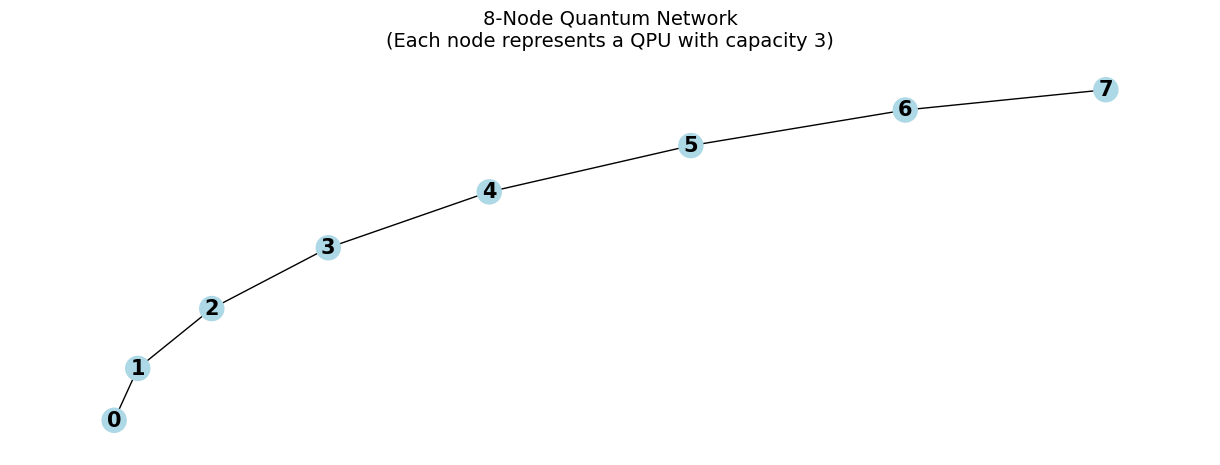

In [42]:
# Problem parameters
num_qubits = 16
num_qpus = 8  # 4-node linear network
qpu_capacity = int(np.ceil(num_qubits / num_qpus)) + 1 
coarsening_factor = 2  # l=2

# Create the quantum circuit (16-qubit Quantum Volume)
from qiskit import transpile
from disqco.circuits.cp_fraction import cp_fraction

# circuit = QuantumVolume(num_qubits, depth=10, seed=42)
circuit = cp_fraction(num_qubits, depth=3*num_qubits, fraction=0.3, seed=764)
# Transpile to the right gate set
circuit = transpile(circuit, basis_gates=['u', 'cp'])

print(f"✅ Created {num_qubits}-qubit circuit")
print(f"   Circuit depth: {circuit.depth()}")
gate_counts = circuit.count_ops()
print(f"   Gate counts: {gate_counts}")

# Create the quantum network (4-node linear topology)
qpu_sizes = [qpu_capacity] * num_qpus  # [4, 4, 4, 4]
connectivity = linear_coupling(num_qpus)  # [(0,1), (1,2), (2,3)]
# connectivity = grid_coupling(num_qpus)  


initial_network = QuantumNetwork(qpu_sizes, connectivity)

network = deepcopy(initial_network)  # Use a copy to avoid modifying the original

print(f"✅ Created {num_qpus}-node linear quantum network")
print(f"   QPU sizes: {qpu_sizes}")
print(f"   Connectivity: {connectivity}")
print(f"   Total capacity: {sum(qpu_sizes)} qubits")

# Create the hypergraph representation
hypergraph = QuantumCircuitHyperGraph(circuit)
print(f"✅ Created hypergraph representation")
print(f"   Number of nodes: {len(hypergraph.nodes)}")
print(f"   Number of hyperedges: {len(hypergraph.hyperedges)}")
print(f"   Circuit depth in hypergraph: {hypergraph.depth}")

# Visualize the network topology
# Scale figure and node sizes based on network size
fig_width = max(8, min(20, num_qpus * 1.5))
plt.figure(figsize=(fig_width, 4))

# Position nodes with proper spacing
spacing = max(1.0, 8.0 / num_qpus)  # Adaptive spacing
# pos = {i: (i * spacing, 0) for i in range(num_qpus)}

# Scale node sizes and font based on network size
base_node_size = max(300, 2000 / num_qpus)  # Smaller nodes for larger networks
node_sizes = [base_node_size * size / max(qpu_sizes) for size in qpu_sizes]
font_size = max(8, min(16, 120 / num_qpus))  # Scale font with network size

nx.draw(network.qpu_graph, with_labels=True, 
        node_size=node_sizes, node_color='lightblue', 
        font_size=font_size, font_weight='bold')

plt.title(f"{num_qpus}-Node Quantum Network\n(Each node represents a QPU with capacity {qpu_capacity})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

### Initial Hypergraph Visualization

Let's visualize the initial hypergraph representation of our quantum circuit. This shows the temporal structure where each node represents a qubit at a specific time step, and hyperedges represent quantum gates.

In [43]:
if len(hypergraph.nodes) < 1500:
    fig = hypergraph.draw(network, show_labels=False, tikz_raw=True)
    print(fig)

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[circle, draw=black, fill=blue!20, scale=0.36]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.220, inner sep=0pt}}
  \tikzset{startQLabel/.style={scale=0.500, inner sep=0pt}}
  \begin{pgfonlayer}{nodelayer}
    \node [style=b

## Step 2: Network Coarsening

The first stage of the algorithm is to coarsen the quantum network. This creates a hierarchy of networks, where each level has fewer nodes but represents the same connectivity structure at a coarser granularity.

In [44]:
# Initialize the network coarsener
net_coarsener = NetworkCoarsener(network)
print(f"🔧 Initialized NetworkCoarsener")
print(f"   Initial network: {net_coarsener.initial_network.num_qpus} QPUs")

# Perform recursive network coarsening
print(f"\\n🔄 Starting recursive network coarsening with l={coarsening_factor}")
start_time = time.time()
net_coarsener.coarsen_network_recursive(l=coarsening_factor)
coarsening_time = time.time() - start_time

print(f"✅ Network coarsening complete in {coarsening_time:.4f} seconds")
print(f"   Number of coarsening levels: {len(net_coarsener.network_coarse_list)}")

# Examine the coarsening hierarchy
print("\\n📊 Network Coarsening Hierarchy:")
for i, network_level in enumerate(net_coarsener.network_coarse_list):
    num_nodes = len(network_level.qpu_graph.nodes)
    qpu_sizes_level = [network_level.qpu_graph.nodes[node]['size'] for node in network_level.qpu_graph.nodes]
    print(f"   Level {i}: {num_nodes} nodes, sizes {qpu_sizes_level}")

# Set up the final coarsened network
final_network = net_coarsener.network_coarse_list[-1]
final_network.active_nodes = set(final_network.qpu_graph.nodes)

🔧 Initialized NetworkCoarsener
   Initial network: 8 QPUs
\n🔄 Starting recursive network coarsening with l=2
✅ Network coarsening complete in 0.0007 seconds
   Number of coarsening levels: 3
\n📊 Network Coarsening Hierarchy:
   Level 0: 8 nodes, sizes [3, 3, 3, 3, 3, 3, 3, 3]
   Level 1: 4 nodes, sizes [5, 5, 5, 5]
   Level 2: 2 nodes, sizes [9, 9]


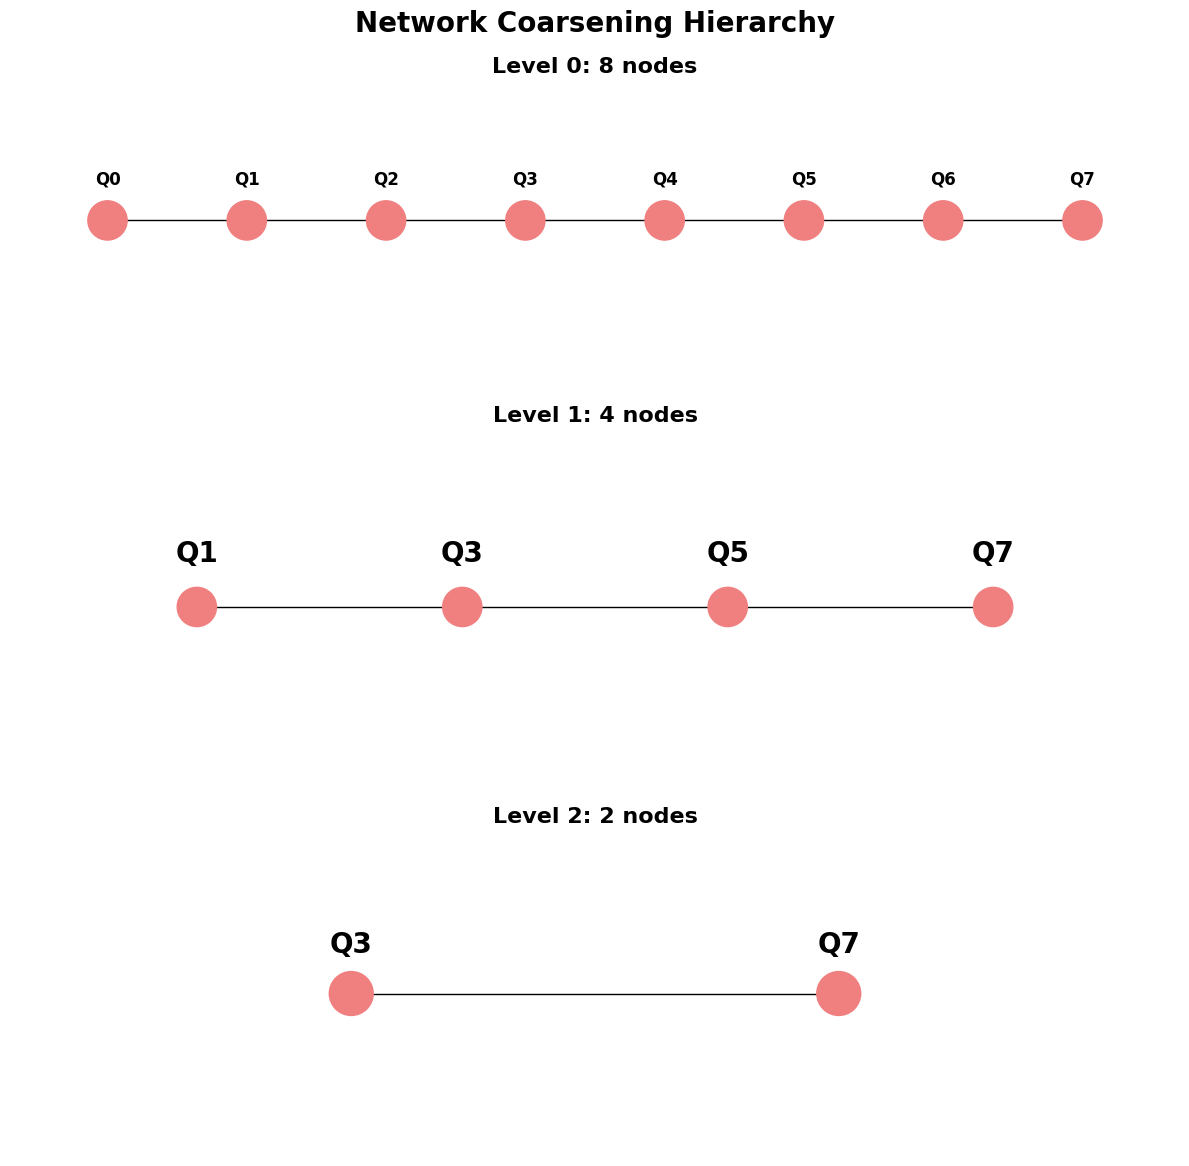

🎨 Network coarsening visualization complete!
   Each level shows the network after coarsening operations
   Node sizes represent QPU capacities (number of qubits each can handle)


In [45]:
# Visualize the network coarsening hierarchy
# Scale figure size based on number of levels and max nodes (vertical layout)
max_nodes_in_level = max(len(level.qpu_graph.nodes) for level in net_coarsener.network_coarse_list)
fig_width = max(8, max_nodes_in_level * 1.5)  # Wider figure for larger nodes
fig_height = max(6, len(net_coarsener.network_coarse_list) * 4)  # Height scales with levels
fig, axes = plt.subplots(len(net_coarsener.network_coarse_list), 1, 
                        figsize=(fig_width, fig_height))

if len(net_coarsener.network_coarse_list) == 1:
    axes = [axes]

for i, network_level in enumerate(net_coarsener.network_coarse_list):
    ax = axes[i]
    
    # Create layout for this network level with adaptive spacing
    G = network_level.qpu_graph
    num_nodes = len(G.nodes)
    
    if num_nodes == 1:
        pos = {list(G.nodes)[0]: (0, 0)}
        spacing = 1
    else:
        spacing = max(1.0, 6.0 / num_nodes)  # Increased spacing for larger nodes
        pos = {node: (idx * spacing, 0) for idx, node in enumerate(G.nodes)}
    
    # Scale node sizes and font based on number of nodes (increased sizes)
    base_size = max(800, 2000 / num_nodes)  # Significantly larger base size
    node_sizes = [base_size * G.nodes[node]['size'] / max(G.nodes[n]['size'] for n in G.nodes) for node in G.nodes]
    font_size = max(12, min(20, 100 / num_nodes))  # Larger font sizes
    
    # Create compact labels (without newlines)
    if num_nodes <= 8:
        node_labels = {node: f"Q{node}" for node in G.nodes}
    else:
        node_labels = {node: f"Q{node}" for node in G.nodes}
    
    # Draw nodes and edges without labels
    nx.draw(G, pos=pos, ax=ax, with_labels=False,
            node_size=node_sizes, node_color='lightcoral')
    
    # Create position for labels above nodes
    label_pos = {node: (x, y + 0.3) for node, (x, y) in pos.items()}
    
    # Draw labels above nodes
    nx.draw_networkx_labels(G, label_pos, labels=node_labels, ax=ax,
                           font_size=int(font_size), font_weight='bold')
    
    ax.set_title(f"Level {i}: {len(G.nodes)} nodes", fontsize=16, fontweight='bold')  # Larger title font
    ax.set_aspect('equal')
    
    # Adjust axis limits based on spacing
    if num_nodes > 1:
        ax.set_xlim(-spacing * 0.7, (num_nodes - 1) * spacing + spacing * 0.7)
    
    # Add more vertical padding
    ax.set_ylim(-1, 1)

plt.suptitle("Network Coarsening Hierarchy", fontsize=20, fontweight='bold')  # Larger main title
plt.tight_layout()
plt.show()

print("🎨 Network coarsening visualization complete!")
print("   Each level shows the network after coarsening operations")
print("   Node sizes represent QPU capacities (number of qubits each can handle)")

## Step 3: Network Cutting and Sub-Network Generation

After coarsening the network, we systematically "cut" or divide it into sub-networks at each level. This creates a tree-like structure where each node in a coarser network corresponds to multiple sub-networks in the finer level.

In [46]:
# Initialize the network level list with the most coarsened network
network_level_list = []
network_level_list.append({None: final_network})  # Dict: {source_node: network}
networks = network_level_list[0]

print(f"🔧 Starting network cutting process")
print(f"   Initial level has {len(networks)} sub-networks")

# Perform network cutting for each coarsening level
start_time = time.time()
for i in range(len(net_coarsener.network_coarse_list) - 1):
    print(f"\n📂 Cutting networks at level {i}")
    prev_networks = network_level_list[i]
    print(f"   Input: {len(prev_networks)} networks")
    
    new_networks = net_coarsener.cut_network(prev_networks, level=i)
    network_level_list.append(new_networks)
    
    print(f"   Output: {len(new_networks)} networks")
    
    # Show details of the new networks
    for source_node, network in new_networks.items():
        active_nodes = network.active_nodes
        node_sizes = [network.qpu_graph.nodes[node]['size'] for node in active_nodes]
        print(f"     Sub-network {source_node}: {len(active_nodes)} active nodes, sizes {node_sizes}")

cutting_time = time.time() - start_time
print(f"\n✅ Network cutting complete in {cutting_time:.4f} seconds")
print(f"   Total levels created: {len(network_level_list)}")

# Summary of the network hierarchy
print("\n📊 Complete Network Hierarchy:")
for level, networks in enumerate(network_level_list):
    print(f"   Level {level}: {len(networks)} sub-networks")
    for source_node, net in networks.items():
        active_nodes = net.active_nodes
        sizes = [net.qpu_graph.nodes[node]['size'] for node in active_nodes]
        print(f"     Sub-net {source_node}: {len(active_nodes)} nodes, sizes {sizes}")

🔧 Starting network cutting process
   Initial level has 1 sub-networks

📂 Cutting networks at level 0
   Input: 1 networks
   Output: 2 networks
     Sub-network 3: 2 active nodes, sizes [5, 5]
     Sub-network 7: 2 active nodes, sizes [5, 5]

📂 Cutting networks at level 1
   Input: 2 networks
   Output: 4 networks
     Sub-network 1: 2 active nodes, sizes [3, 3]
     Sub-network 3: 2 active nodes, sizes [3, 3]
     Sub-network 5: 2 active nodes, sizes [3, 3]
     Sub-network 7: 2 active nodes, sizes [3, 3]

✅ Network cutting complete in 0.0003 seconds
   Total levels created: 3

📊 Complete Network Hierarchy:
   Level 0: 1 sub-networks
     Sub-net None: 2 nodes, sizes [9, 9]
   Level 1: 2 sub-networks
     Sub-net 3: 2 nodes, sizes [5, 5]
     Sub-net 7: 2 nodes, sizes [5, 5]
   Level 2: 4 sub-networks
     Sub-net 1: 2 nodes, sizes [3, 3]
     Sub-net 3: 2 nodes, sizes [3, 3]
     Sub-net 5: 2 nodes, sizes [3, 3]
     Sub-net 7: 2 nodes, sizes [3, 3]


Visualizing network cutting hierarchy...


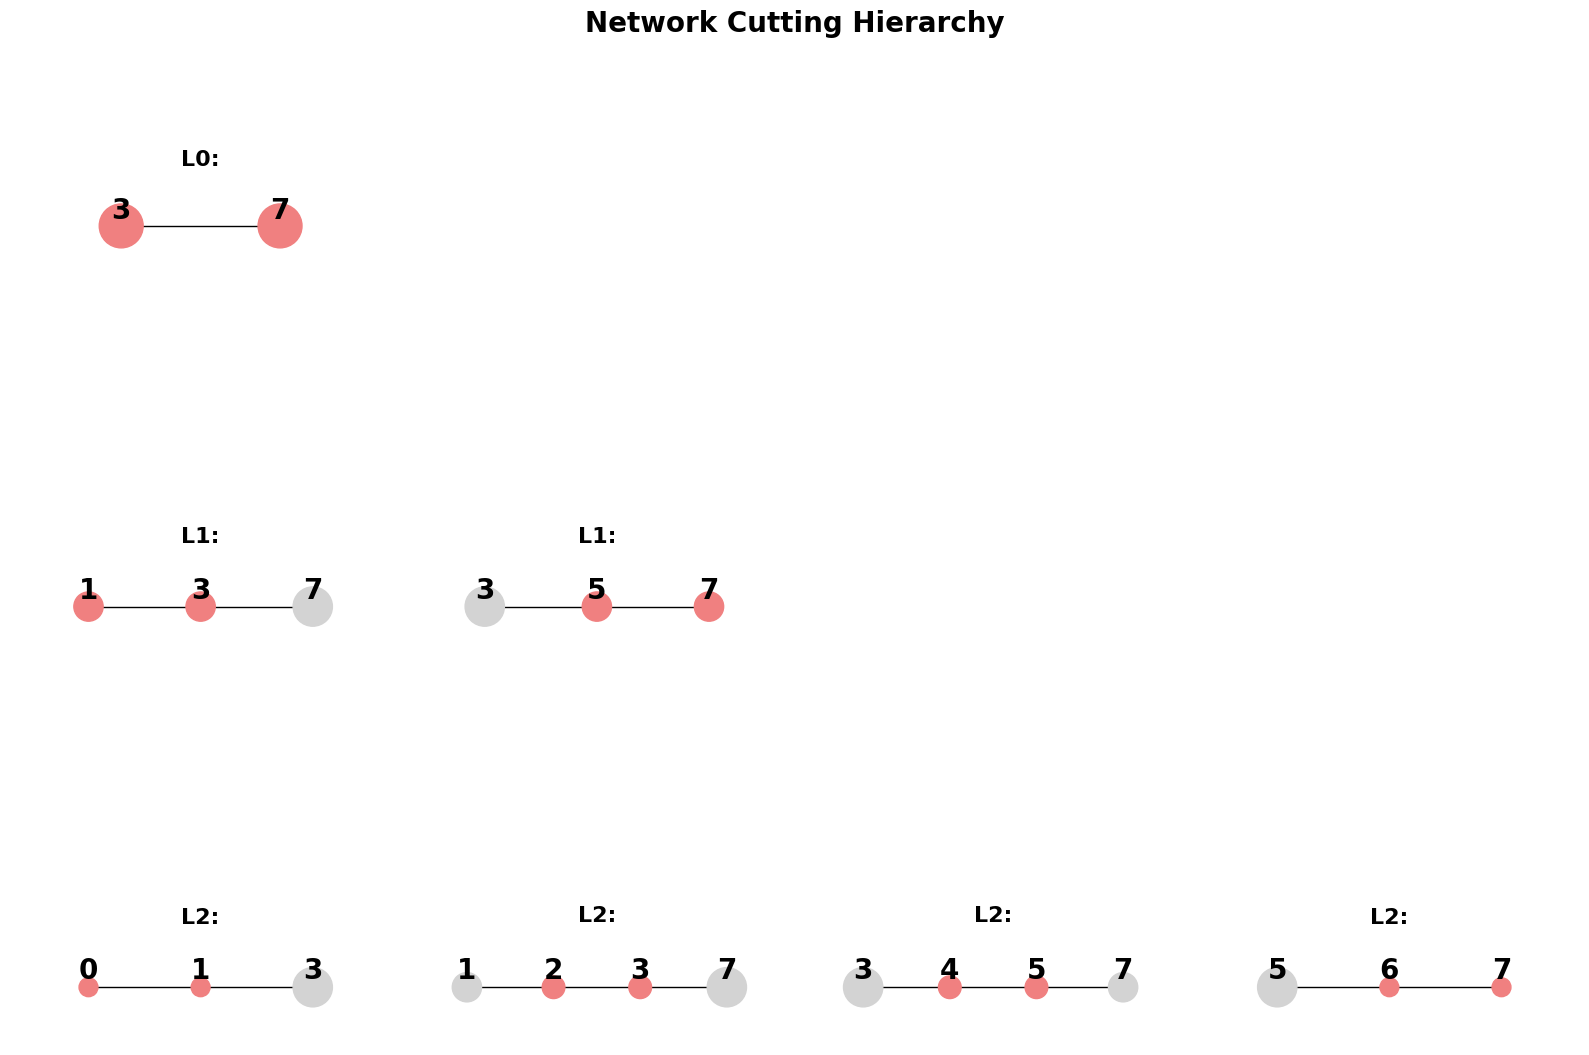

✅ Network cutting visualization complete!
   Each row shows a different coarsening level
   Each column shows a different sub-network at that level
   Red nodes are active in the sub-network, grey nodes are dummy nodes


In [47]:
# Visualize the network cutting hierarchy
print("Visualizing network cutting hierarchy...")

max_networks = max(len(networks) for networks in network_level_list)
fig_width = max(8, max_networks * 4)  # Wider figure for larger nodes
fig_height = max(6, len(network_level_list) * 4)  # Height scales with levels
fig, axes = plt.subplots(len(network_level_list), max_networks, 
                        figsize=(fig_width, fig_height))

# Handle case where there's only one level or one network
if len(network_level_list) == 1:
    axes = [axes]
if max_networks == 1:
    axes = [[ax] for ax in axes]

for level_idx, networks in enumerate(network_level_list):
    for net_idx, (source_node, network) in enumerate(networks.items()):
        if net_idx < max_networks:  # Ensure we don't exceed subplot grid
            ax = axes[level_idx][net_idx]
            
            G = network.qpu_graph
            active_nodes = network.active_nodes
            num_nodes = len(G.nodes)
            
            if num_nodes == 0:
                ax.set_title(f"L{level_idx}-Net{source_node}: Empty")
                ax.axis('off')
                continue
            
            # Sort nodes by index in ascending order for consistent positioning
            sorted_nodes = sorted(G.nodes, key=lambda x: (isinstance(x, tuple) and x[0] == 'dummy', x))
            
            # Create layout with adaptive spacing
            if num_nodes == 1:
                pos = {sorted_nodes[0]: (0, 0)}
                spacing = 1
            else:
                spacing = max(1.0, 6.0 / num_nodes)  # Increased spacing for larger nodes
                pos = {node: (idx * spacing, 0) for idx, node in enumerate(sorted_nodes)}
            
            # Color nodes: lightcoral for active, lightgrey for inactive/dummy
            node_colors = ['lightcoral' if node in active_nodes else 'lightgrey' for node in G.nodes]
            
            # Scale node sizes (significantly larger like previous visualization)
            base_size = max(800, 2000 / num_nodes)
            node_sizes = [base_size * G.nodes[node]['size'] / max(G.nodes[n]['size'] for n in G.nodes) for node in G.nodes]
            font_size = max(12, min(20, 100 / num_nodes))  # Larger font sizes
            
            # # Create labels without newlines
            # if num_nodes <= 8:
            #     node_labels = {node: f"QPU {node} ({G.nodes[node]['size']})" for node in sorted_nodes}
            # else:
            #     node_labels = {node: f"{node} ({G.nodes[node]['size']})" for node in sorted_nodes}
            
            # Draw nodes and edges without labels
            nx.draw(G, pos=pos, ax=ax, with_labels=False,
                    node_size=node_sizes, node_color=node_colors)
            
            # Create position for labels above nodes
            label_pos = {node: (x, y + 0.3) for node, (x, y) in pos.items()}
            
            # Draw labels above nodes
            nx.draw_networkx_labels(G, label_pos, ax=ax,
                                   font_size=int(font_size), font_weight='bold')
            
            ax.set_title(f"L{level_idx}:", 
                        fontsize=16, fontweight='bold')  # Larger title font
            ax.set_aspect('equal')
            
            # Adjust axis limits based on spacing
            if num_nodes > 1:
                ax.set_xlim(-spacing * 0.7, (num_nodes - 1) * spacing + spacing * 0.7)
            
            # Add more vertical padding
            ax.set_ylim(-1, 1)
    
    # Hide unused subplots
    for net_idx in range(len(networks), max_networks):
        if net_idx < max_networks:
            axes[level_idx][net_idx].set_visible(False)

plt.suptitle("Network Cutting Hierarchy", fontsize=20, fontweight='bold')  # Larger main title
plt.tight_layout()
plt.show()

print("✅ Network cutting visualization complete!")
print("   Each row shows a different coarsening level")
print("   Each column shows a different sub-network at that level")
print("   Red nodes are active in the sub-network, grey nodes are dummy nodes")

## Initial Partitioning on Coarsest Network

Before creating subgraphs, we need to perform an initial partitioning of the circuit on the coarsest network level. This provides the baseline assignment that will be used to determine which nodes become "dummy nodes" in each subgraph.

In [48]:

# Perform initial partitioning on the coarsest network
print("🎯 Performing initial partitioning on coarsest network...")

# Use the coarsest network (first level in our hierarchy)
coarsest_networks = network_level_list[0]
coarsest_network = list(coarsest_networks.values())[0]
coarsest_active_nodes = coarsest_network.active_nodes

print(f"   Coarsest network: {len(coarsest_active_nodes)} active nodes")
print(f"   Active nodes: {list(coarsest_active_nodes)}")

# Set up initial assignment using simple strategy
num_coarsest_qpus = len(coarsest_active_nodes)


# Run FM optimization on the coarsest level to get a good starting point
print("\\n🔧 Running FM optimization on coarsest network...")

# Create node mapping for coarsest network
coarsest_node_map = {list(coarsest_active_nodes)[i] : i for i in range(len(coarsest_active_nodes))}
# Create sparse assignment for coarsest network
coarsest_qpu_sizes = {qpu: coarsest_network.qpu_graph.nodes[qpu]['size'] for qpu in coarsest_active_nodes}

initial_assignment_coarse = set_initial_partition_assignment(
    graph=hypergraph,
    network=coarsest_network,
    node_map=coarsest_node_map,
)



from disqco.parti.FM.fiduccia import *

FM_partitioner = FiducciaMattheyses(circuit=circuit,
                                    network=coarsest_network,
                                    initial_assignment=initial_assignment_coarse,
                                    sparse=True )

coarsener = HypergraphCoarsener()
coarsening_method = coarsener.coarsen_recursive_subgraph_batch
results = FM_partitioner.multilevel_partition(coarsener=coarsening_method, sparse=True)
# results = FM_partitioner.partition(sparse=True)

optimized_assignment_coarse = results['best_assignment']
best_cost = results['best_cost']

optimization_time = time.time() - start_time

print(f'Best assignment on coarsest network: {optimized_assignment_coarse}')
print(f'Best cost on coarsest network: {best_cost}')

🎯 Performing initial partitioning on coarsest network...
   Coarsest network: 2 active nodes
   Active nodes: [3, 7]
\n🔧 Running FM optimization on coarsest network...
Best assignment on coarsest network: [[3 3 7 7 3 3 3 7 7 7 7 3 3 7 7 3]
 [3 3 7 7 3 3 3 7 7 7 7 3 3 7 3 3]
 [3 3 7 7 3 3 3 7 7 7 7 3 3 7 3 3]
 [3 3 7 7 3 3 3 7 7 7 7 3 3 7 3 3]
 [3 3 7 7 3 3 3 7 7 7 7 3 3 7 3 3]
 [3 3 7 7 3 3 3 7 7 7 7 3 3 7 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 3 3 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 3 3 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 3 3 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 3 3 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 3 3 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 7 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3 7 3 3 3]
 [3 3 7 7 3 3 7 7 7 3 7 3

In [49]:
# Visualize the optimized assignment using TikZ
print("\\n🎨 Drawing optimized assignment with TikZ...")

fig = draw_subgraph_tikz(hypergraph, initial_assignment_coarse, coarsest_qpu_sizes, 
                         node_map=coarsest_node_map,
                         network=coarsest_network,
                         fill_background=True, show_labels=False, tikz_raw=True)
print(fig)

fig = draw_subgraph_tikz(hypergraph, optimized_assignment_coarse, coarsest_qpu_sizes, 
                         node_map=coarsest_node_map,
                         network=coarsest_network,
                         fill_background=True, show_labels=False, tikz_raw=True)
print(fig)


\n🎨 Drawing optimized assignment with TikZ...
\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style

## Subgraph Creation with Dummy Nodes

Now we create subgraphs from the original hypergraph for each sub-network. The key innovation is that nodes belonging to other partitions are replaced with "dummy nodes" that represent the external partitions. This allows each subgraph to be optimized independently while maintaining awareness of external dependencies.

In [50]:
# Initialize subgraph management
sub_graph_manager = SubGraphManager(hypergraph)
print(f"🔧 Initialized SubGraphManager")


print(networks)

# Use the SubGraphManager to create actual subgraphs with dummy nodes
subgraphs = sub_graph_manager.build_partition_subgraphs(
    graph=hypergraph,
    assignment=optimized_assignment_coarse,
    current_network=coarsest_network,
    new_networks=network_level_list[1],
    old_dummy_nodes=set()
)

print(f"   ✅ Successfully created {len(subgraphs)} subgraphs with dummy nodes!")


🔧 Initialized SubGraphManager
{1: <disqco.graphs.quantum_network.QuantumNetwork object at 0x10986f750>, 3: <disqco.graphs.quantum_network.QuantumNetwork object at 0x10986f110>, 5: <disqco.graphs.quantum_network.QuantumNetwork object at 0x10986c870>, 7: <disqco.graphs.quantum_network.QuantumNetwork object at 0x10986d3b0>}
   ✅ Successfully created 2 subgraphs with dummy nodes!


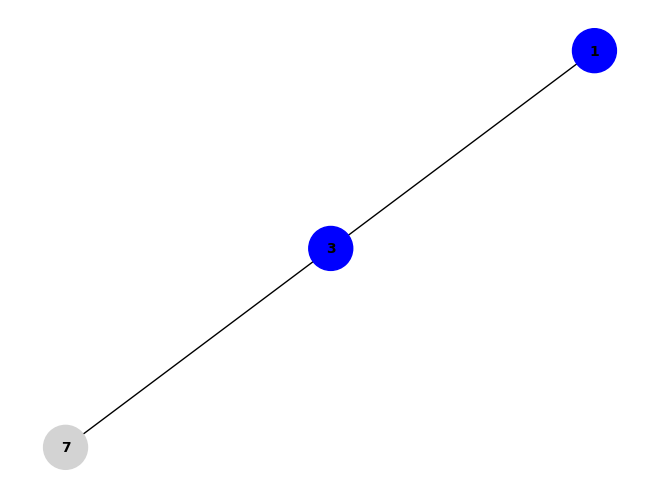

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style=boundaryLine] (1.659,2.077) -- (12.227,2.077)

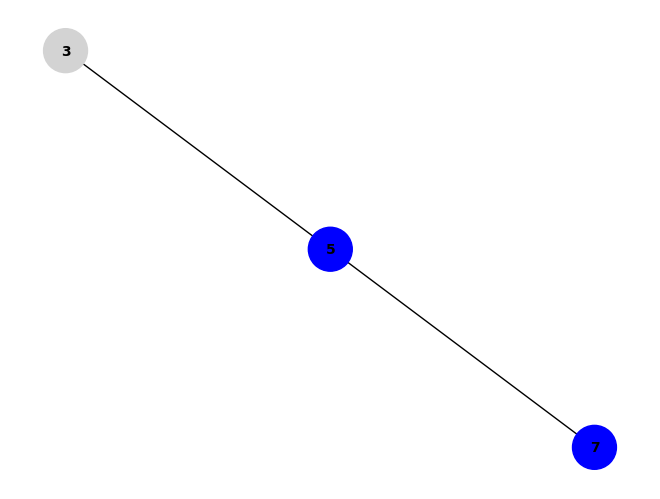

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style=boundaryLine] (1.659,2.250) -- (12.227,2.250)

In [ ]:

coarsener = HypergraphCoarsener()

# Iterate through dictionary of subgraphs
sparse_assignments = []
for source_node, subgraph in subgraphs.items():

    sub_network = network_level_list[1][source_node]
    active_nodes = sub_network.active_nodes
    qpu_sizes = {node: sub_network.qpu_graph.nodes[node]['size'] for node in active_nodes}
    node_colors = ['blue' if node in active_nodes else 'lightgray' for node in sub_network.qpu_graph.nodes]
    nx.draw(sub_network.qpu_graph, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold')
    plt.show()

    node_map = {node: idx for idx, node in enumerate(active_nodes)}


    sparse_assignment = set_initial_partitions_sparse(
        assignment=optimized_assignment_coarse,
        active_nodes=active_nodes,
        qpu_sizes=qpu_sizes,
        subgraph=subgraph
    )
    initial_sparse_assignment = sparse_assignment.copy()


    partitioner = FiducciaMattheyses(
    circuit=circuit,
    initial_assignment=sparse_assignment,
    hypergraph=subgraph,
    qpu_info=qpu_sizes,
    num_partitions=len(active_nodes),
    active_nodes=active_nodes,
    limit=num_qubits,
    max_gain=4*hypergraph.depth,
    passes=10,
    stochastic=True,
    network=sub_network,
    node_map=node_map,
    sparse=True
    )
    results = partitioner.partition(hypergraph_coarsener=HypergraphCoarsener().coarsen_recursive_subgraph_batch, 
                                    sparse=True, level_limit=100, 
                                    passes_per_level=10)
    
    sparse_assignment = results['best_assignment']
    final_cost = results['best_cost']

    fig= draw_subgraph_tikz(subgraph,
    sparse_assignment,
    qpu_sizes,
    network=sub_network,
    node_map=node_map,
    show_labels=False,
    tikz_raw=True)
    print(fig)

    fig= draw_subgraph_tikz(subgraph,
    sparse_assignment,
    qpu_sizes,
    network=sub_network,
    node_map=node_map,
    show_labels=False,
    tikz_raw=True)
    print(fig)
    
    # Check validity of the final sparse assignment
    if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
        print("❌ Final sparse assignment is invalid!")
        raise ValueError("Final sparse assignment does not respect QPU capacities or active nodes.")

    sparse_assignments.append(sparse_assignment)


    
print(f"   ✅ Subgraph {i} TikZ visualization complete!")

print("\\n✅ Subgraph visualization complete!")
print("   Each visualization shows the circuit from one sub-network's perspective")
print("   Real nodes belong to the sub-network, dummy nodes represent external qubits")
print("   This enables independent optimization while preserving global dependencies")

In [52]:


parent_assignment = stitch_solution_sparse(subgraphs, sparse_assignments, num_qubits, depth=hypergraph.depth)

final_cost = calculate_full_cost_hetero(hypergraph, parent_assignment, len(initial_network.qpu_sizes), {}, initial_network)

print(f"Final cost of the stitched solution: {final_cost}")

network_level_1 = net_coarsener.network_coarse_list[-2]

print("Network level 1 QPU sizes:", network_level_1.qpu_sizes)


Final cost of the stitched solution: 122
Network level 1 QPU sizes: {1: 5, 3: 5, 5: 5, 7: 5}


## Step 5.6: Create Second Level Subgraphs

Now we create subgraphs for the second level of network coarsening. Each optimized subgraph from the first level is further divided based on the second level of network cutting.

In [53]:
# Create second level subgraphs
print("Creating second level subgraphs...")
if len(network_level_list) > 2:
    all_new_subgraphs = {}
    print(subgraphs)
    counter = 0
    for i, (source_node, subgraph) in enumerate(subgraphs.items()):
        print(f"\n📂 Processing subgraph {i} (source: {source_node}) for second level...")
        print(f'Counter: {counter}')
        counter += 1
        
        # Get the optimized assignment for this subgraph
        optimized_assignment = sparse_assignments[i]
        # Find existing dummy nodes
        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) > 0 and node[0] == 'dummy':
                dummy_nodes.add(node)
        
        current_network = network_level_list[1][source_node]
        
        # Create new subgraphs for second level
        new_subgraphs = sub_graph_manager.build_partition_subgraphs(
            graph=subgraph,
            assignment=optimized_assignment,
            current_network=current_network,
            new_networks=network_level_list[2],
            old_dummy_nodes=dummy_nodes
        )

        all_new_subgraphs.update(new_subgraphs)

    print(f"✅ Created {len(all_new_subgraphs)} second-level subgraphs")

Creating second level subgraphs...
{3: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x108fc3ac0>, 7: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x10925b960>}

📂 Processing subgraph 0 (source: 3) for second level...
Counter: 0

📂 Processing subgraph 1 (source: 7) for second level...
Counter: 1
✅ Created 4 second-level subgraphs


🔧 Partitioning second level subgraphs...
{1: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x10925af10>, 3: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x10925b120>, 5: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x10925b070>, 7: <disqco.graphs.QC_hypergraph.QuantumCircuitHyperGraph object at 0x10925adb0>}


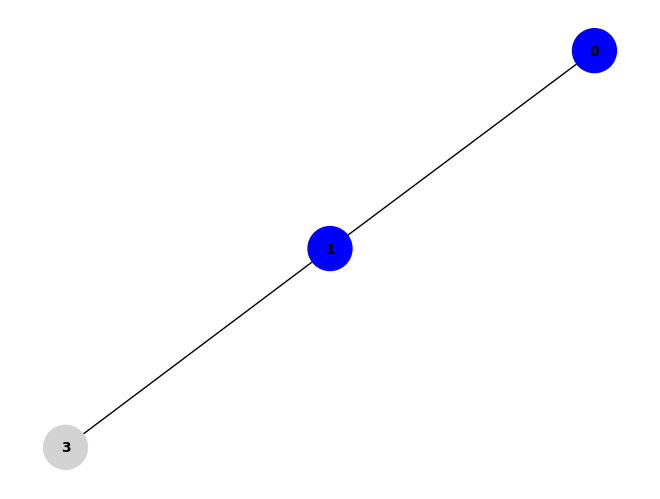

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style=boundaryLine] (1.659,1.667) -- (12.227,1.667)

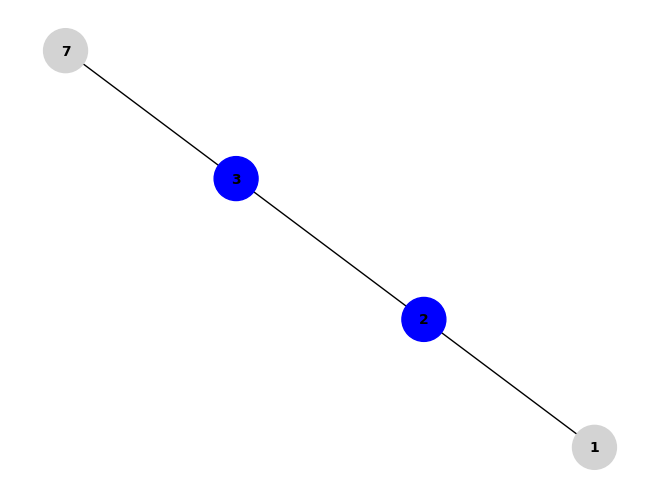

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style=boundaryLine] (1.659,1.154) -- (12.227,1.154)

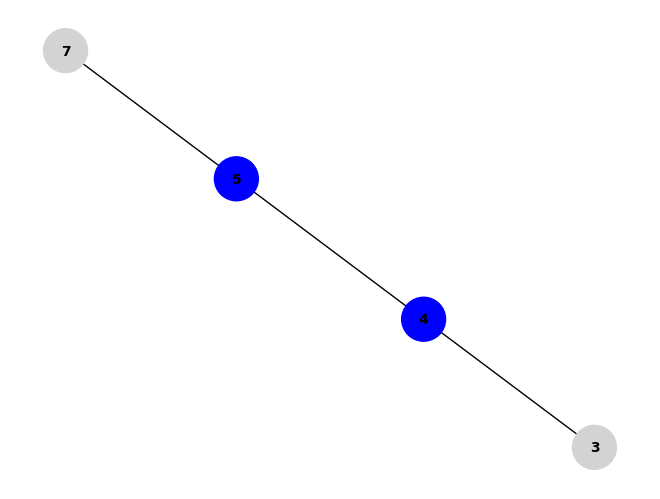

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style=boundaryLine] (1.659,1.500) -- (12.227,1.500)

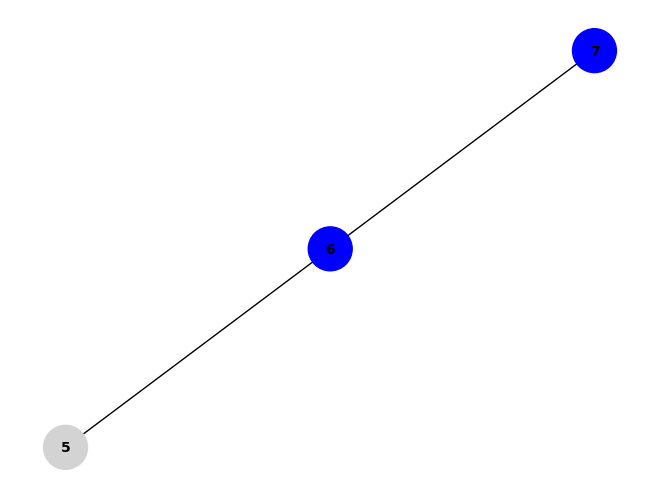

\documentclass[tikz,border=2pt]{standalone}
\usepackage{tikz}
\usetikzlibrary{calc,backgrounds}
\pgfdeclarelayer{nodelayer}
\pgfdeclarelayer{edgelayer}
\pgfsetlayers{background,edgelayer,nodelayer,main}
\begin{document}
\begin{tikzpicture}[>=latex, show background rectangle, background rectangle/.style={fill=white}]
  \tikzstyle{whiteSmallStyle}=[circle, draw=black, fill=white, scale=0.15]
  \tikzstyle{blackStyle}=[circle, draw=black, fill=black, scale=0.3]
  \tikzstyle{whiteStyle}=[circle, draw=black, fill=white, scale=0.3]
  \tikzstyle{greyStyle}=[circle, draw=black, fill=gray, scale=0.3]
  \tikzstyle{invisibleStyle}=[inner sep=0pt, scale=0.1, draw=none]
  \tikzstyle{dummyStyle}=[rectangle, draw=black, fill=red!30, scale=0.6, minimum size=8pt]
  \tikzset{edgeStyle/.style={draw=black}}
  \tikzset{boundaryLine/.style={draw=black, dashed}}
  \tikzset{nodeLabel/.style={scale=0.4, inner sep=1pt}}
  \begin{pgfonlayer}{edgelayer}
    \draw[style=boundaryLine] (1.659,1.875) -- (12.227,1.875)

In [54]:

print("🔧 Partitioning second level subgraphs...")

if len(network_level_list) > 2:

    coarsener = HypergraphCoarsener()

    second_level_sparse_assignments = []
    subgraphs = all_new_subgraphs

    print(subgraphs)

    for source_node, subgraph in subgraphs.items():

        sub_network = network_level_list[2][source_node]
        active_nodes = sub_network.active_nodes
        qpu_sizes = {node: sub_network.qpu_graph.nodes[node]['size'] for node in active_nodes}

        node_colors = ['blue' if node in active_nodes else 'lightgray' for node in sub_network.qpu_graph.nodes]
        nx.draw(sub_network.qpu_graph, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold')
        plt.show()

        node_map = {node: idx for idx, node in enumerate(active_nodes)}
        
        sparse_assignment = set_initial_partitions_sparse(
            assignment=parent_assignment,
            active_nodes=active_nodes,
            qpu_sizes=qpu_sizes,
            subgraph=subgraph
        )
        
        # Use coarsen_recursive_subgraph_batch and multilevel optimization
        partitioner = FiducciaMattheyses(
            circuit=None,
            initial_assignment=sparse_assignment,
            hypergraph=subgraph,
            qpu_info=qpu_sizes,
            num_partitions=len(active_nodes),
            active_nodes=active_nodes,
            limit=num_qubits,
            max_gain=4*hypergraph.depth,
            passes=10,
            stochastic=True,
            network=sub_network,
            node_map=node_map,
            sparse=True
        )
        results = partitioner.partition(hypergraph_coarsener=HypergraphCoarsener().coarsen_recursive_subgraph_batch, 
                                        sparse=True, level_limit=100, 
                                        passes_per_level=10)
        
        sparse_assignment = results['best_assignment']
        final_cost = results['best_cost']



        fig = draw_subgraph_tikz(
            subgraph,
            sparse_assignment,
            qpu_sizes,
            network=sub_network,
            node_map=node_map,
            fill_background=True,
            show_labels=False,
            tikz_raw=True
        )
        print(fig)
        fig = draw_subgraph_tikz(
            subgraph,
            sparse_assignment,
            qpu_sizes,
            network=sub_network,
            node_map=node_map,
            fill_background=True,
            show_labels=False,
            tikz_raw=True
        )
        print(fig)
        # Check validity of the final sparse assignment
        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Final sparse assignment is invalid!")
            raise ValueError("Final sparse assignment does not respect QPU capacities or active nodes.")
        
        second_level_sparse_assignments.append(sparse_assignment)

    print("\n✅ Second level subgraph optimization complete!")
    print("   Each visualization shows the optimized circuit from each second-level sub-network's perspective")
    print("   Real nodes belong to the sub-network, dummy nodes represent external qubits")

In [55]:

from disqco.parti.FM.FM_methods import calculate_full_cost_hetero

print(f'Number of second-level sparse assignments: {len(second_level_sparse_assignments)}')
print(f'Number of subgraphs: {len(subgraphs)}')
parent_assignment = stitch_solution_sparse(subgraphs, second_level_sparse_assignments, num_qubits, depth=hypergraph.depth)

final_cost = calculate_full_cost_hetero(hypergraph, parent_assignment, len(initial_network.qpu_sizes), {}, initial_network)

print(f"Final cost of the stitched solution: {final_cost}")

network_level_2 = net_coarsener.network_coarse_list[-3]

if check_assignment_validity(parent_assignment, network_level_2.qpu_sizes, hypergraph):
    print("✅ Final assignment is valid!")
else:
    print("❌ Final assignment is NOT valid! Check capacity constraints and partitioning.")

# draw_graph_tikz(
#     hypergraph,
#     final_assignment,
#     initial_network.qpu_sizes,
#     fill_background=True,
#     show_labels=True
# )

Number of second-level sparse assignments: 4
Number of subgraphs: 4
Final cost of the stitched solution: 119
✅ Final assignment is valid!


In [56]:
# Create third level subgraphs
print("🔧 Creating third level subgraphs...")

if len(network_level_list) > 3:

    all_new_subgraphs = {}
    counter = 0
    for i, (source_node, subgraph) in enumerate(subgraphs.items()):
        print(f"\n📂 Processing subgraph {i} (source: {source_node}) for third level...")
        print(f'Counter: {counter}')
        counter += 1
        
        # Get the optimized assignment for this subgraph
        optimized_assignment = second_level_sparse_assignments[i]
        # Find existing dummy nodes
        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) > 0 and node[0] == 'dummy':
                dummy_nodes.add(node)
        
        current_network = network_level_list[2][source_node]
        
        # Create new subgraphs for second level
        new_subgraphs = sub_graph_manager.build_partition_subgraphs(
            graph=subgraph,
            assignment=optimized_assignment,
            current_network=current_network,
            new_networks=network_level_list[3],
            old_dummy_nodes=dummy_nodes
        )

        all_new_subgraphs.update(new_subgraphs)

    print(f"✅ Created {len(all_new_subgraphs)} second-level subgraphs")




🔧 Creating third level subgraphs...


In [57]:
# Third level partitioning

if len(network_level_list) > 3:

    print("🔧 Partitioning third level subgraphs...")

    coarsener = HypergraphCoarsener()

    # Iterate through dictionary of third level subgraphs
    third_level_sparse_assignments = []
    subgraphs = all_new_subgraphs

    print(subgraphs)

    for source_node, subgraph in subgraphs.items():

        sub_network = network_level_list[3][source_node]
        active_nodes = sub_network.active_nodes
        qpu_sizes = {node: sub_network.qpu_graph.nodes[node]['size'] for node in active_nodes}
        node_map = {node: idx for idx, node in enumerate(active_nodes)}

        dummy_nodes = set()
        for node in subgraph.nodes:
            if isinstance(node, tuple) and len(node) >= 3 and node[0] == 'dummy':
                dummy_nodes.add(node)
                qpu = node[2]
                node_map[qpu] = len(node_map)  # Assign dummy nodes to the end of the map

        
        sparse_assignment = set_initial_partitions_sparse(
            assignment=parent_assignment,
            active_nodes=active_nodes,
            qpu_sizes=qpu_sizes,
            subgraph=subgraph
        )

        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Sparse assignment is invalid!")
            raise ValueError("Sparse assignment does not respect QPU capacities or active nodes.")
        print(f"Assignment is valid for subgraph {source_node}")

        init_cost = calculate_full_cost_hetero(
            hypergraph=subgraph,
            assignment=sparse_assignment,
            num_partitions=len(active_nodes),
            costs={},
            network=sub_network,
            node_map=node_map,
            dummy_nodes=dummy_nodes
        )

        partitioner = FiducciaMattheyses(
            circuit=circuit,
            initial_assignment=sparse_assignment,
            hypergraph=subgraph,
            qpu_info=qpu_sizes,
            num_partitions=len(active_nodes),
            active_nodes=active_nodes,
            limit=num_qubits,
            max_gain=4*hypergraph.depth,
            passes=10,
            stochastic=True,
            network=sub_network,
            node_map=node_map,
            sparse=True
        )
        results = partitioner.multilevel_partition(coarsener=HypergraphCoarsener().coarsen_recursive_subgraph_batch, 
                                        sparse=True, level_limit=100, 
                                        passes_per_level=10)
        
        sparse_assignment = results['best_assignment']
        final_cost = results['best_cost']

        # Check validity of the final sparse assignment
        if not check_assignment_validity(sparse_assignment, qpu_sizes, subgraph):
            print("❌ Final sparse assignment is invalid!")
            raise ValueError("Final sparse assignment does not respect QPU capacities or active nodes.")
        
        third_level_sparse_assignments.append(sparse_assignment)

    print("\n✅ Third level subgraph optimization complete!")
    print("   Each visualization shows the optimized circuit from each third-level sub-network's perspective")
    print("   Real nodes belong to the sub-network, dummy nodes represent external qubits")

## Step 5.8: Stitch Solutions Together

The final step is to combine all the optimized subgraph solutions into a single complete assignment using the sparse solution stitching method.

In [58]:
# Stitch second-level solutions

if len(network_level_list) > 3:

    final_assignment_unwrapped = stitch_solution_sparse(
        subgraphs, third_level_sparse_assignments, num_qubits, depth=hypergraph.depth
    )

    network_level_3 = net_coarsener.network_coarse_list[-4]

    print("Network level 3 QPU sizes:", network_level_3.qpu_sizes)


    # Check final assignment validity
    if check_assignment_validity(final_assignment_unwrapped, network_level_3.qpu_sizes, hypergraph):
        print("✅ Final scond-level assignment is valid!")
    else:
        print("❌ Final -level assignment is NOT valid! Check capacity constraints and partitioning.")
        raise ValueError("Final assignment does not satisfy capacity constraints.")

    final_cost = calculate_full_cost_hetero(
        hypergraph, final_assignment_unwrapped, len(initial_network.qpu_sizes), {}, initial_network)

    print(f"Final cost of the stitched second-level solution: {final_cost}")

else:
    final_assignment_unwrapped = stitch_solution_sparse(
        subgraphs, second_level_sparse_assignments, num_qubits, depth=hypergraph.depth
    )

In [59]:
fig = draw_subgraph_tikz(
    hypergraph,
    final_assignment_unwrapped,
    initial_network.qpu_sizes,
    network=initial_network,
    show_labels=False
)
print(fig)

<IPython.core.display.Image object>


To run the full process, use the ```run_full_net_coarsened_FM``` function. This can also be accessed via the ```partitioner``` class.

In [60]:
from disqco.parti.FM.net_coarsened_partitioning import run_full_net_coarsened_FM

# Example usage:
results = run_full_net_coarsened_FM(
    hypergraph=hypergraph,
    num_qubits=num_qubits,
    network=initial_network,
    coarsening_factor=4,
    passes_per_level=10,
    use_multiprocessing=True,
)
final_assignment = results['best_assignment']
print(f"Final cost: {results['best_cost']}")



# Check final assignment validity
if check_assignment_validity(final_assignment, initial_network.qpu_sizes, hypergraph):
    print("✅ Final assignment is valid!")
else:
    print("❌ Final assignment is NOT valid! Check capacity constraints and partitioning.")
    print(f"Previous solution validity: {check_assignment_validity(final_assignment_unwrapped, initial_network.qpu_sizes, hypergraph)}")
    raise ValueError("Final assignment does not satisfy capacity constraints.")

Final cost: 122
✅ Final assignment is valid!
